# A quick intro to `mandala`
`mandala` eliminates the developer effort typically required to persist, iterate
on, query, version and reproduce results of computational projects, such as
machine learning experiments. 

It works by automatically capturing inputs, outputs, and code (+dependencies) at
calls of `@op`-decorated functions. A `ComputationFrame` data structure over
this information enables easy queries and high-level operations over program
traces.

In [ ]:
# Run this if in a Google Colab notebook
!pip install git+https://github.com/amakelov/mandala

## The `@op` decorator: automatic memoization and code tracking
`@op` tracks the inputs, outputs, code and dependencies of calls to Python
functions. The same call is never executed twice:

In [13]:
from mandala.imports import *
import time

storage = Storage( # stores all `@op` calls
    # where to look for dependencies; use `None` to prevent versioning altogether
    deps_path='__main__' 
    ) 

@op
def inc(x):
    print("Hello from inc!")
    time.sleep(1) # simulate a long operation
    return x + 1

with storage: # all `@op` calls inside this block will be stored in `storage`
    start = time.time()
    a = inc(1)
    b = inc(1) # this will not be executed, but reused
    end = time.time()
    print(f'Took {round(end - start)} seconds')

Hello from inc!
Took 1 seconds


## `ComputationFrame`s: generalized dataframes for querying program traces
`@op`s are designed to be composed with one another like ordinary Python
functions. This automatically keeps track of the relationships between all saved
objects. 

`ComputationFrame`s are a natural **high-level view** of these relationships:

Computation frame for `inc`:


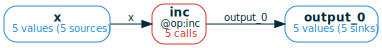

Expanded computation frame for `inc`:


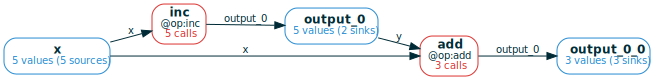

In [18]:
@op # define a new @op to compose with `inc`
def add(x, y):
    print("Hello from add!")
    return x + y

with storage:
    for i in range(5):
        j = inc(i)
        if i % 2 == 0:
            k = add(i, j)

# get the computation frame for all calls to `inc` - which is a lot like 
# the memoization table for `inc` 
cf = storage.cf(inc) 
print('Computation frame for `inc`:')
cf.draw(verbose=True, orientation='LR') # visualize the computation frame

# expand the computation frame to include all calls connected to the calls of
# `inc` through shared inputs/outputs
cf.expand(inplace=True) 
print('Expanded computation frame for `inc`:')
cf.draw(verbose=True, orientation='LR', path='test.jpg') # visualize the computation frame

## Computation frames generalize dataframes to operate over computation traces
- **columns are replaced by a computational graph**: functions whose input/output
edges connect to variables.
- **rows are replaced by computation traces**: variable values and function
calls that (possibly partially) follow this graph

**A dataframe can be extracted from any computation frame** for easier later
analysis:
- the columns are the nodes in the graph (functions and variables)
- each row is a computation trace, possibly padded with `NaN`s where no
value/call is present:

In [15]:
cf.df()

Extracting tuples from the computation graph:
    output_0@output_0 = inc(x=x)
    output_0_0@output_0 = add(x=x, y=output_0)


,x,inc,output_0,add,output_0_0
0,0,"Call(inc, cid='355...', hid='52f...')",1,"Call(add, cid='16b...', hid='38e...')",1.0
1,3,"Call(inc, cid='56b...', hid='f62...')",4,None,NaN
2,4,"Call(inc, cid='16b...', hid='f05...')",5,"Call(add, cid='2ee...', hid='5f0...')",9.0
3,2,"Call(inc, cid='c38...', hid='ec7...')",3,"Call(add, cid='bbb...', hid='d3f...')",5.0
4,1,"Call(inc, cid='9d3...', hid='66c...')",2,None,NaN


## Automatic per-call versioning w/ dependency tracking
Changing memoized functions may invalidate their past calls - but not all
changes invalidate all calls, and some "non-semantic" changes invalidate no
calls at all. 

To help with that, `mandala` can automatically track marked (with `@track`)
dependencies of each call to an `@op`, and watch for changes in their code:

In [7]:
@op # define a new @op to compose with `inc`
def add(x, y):
    print("Hello from add!")
    return x + square(y)

@track # dependency tracking decorator
def square(num):
    return num**2

# same computations as before, change to `add` will be detected
with storage:
    for i in range(5):
        j = inc(i)
        if i % 2 == 0:
            k = add(i, j)

CHANGE DETECTED in add from module __main__
Dependent components:
  Version of "add" from module "__main__" (content: 7cd06a0178abc60d137bb47bceafa5f9, semantic: 455b6b8789fb67940e41dbbb135292f7)
===DIFF===:
 def add(x, y):
     print("Hello from add!")
-    return x + y
+    return x + square(y)
Does this change require recomputation of dependent calls?
Answer: [y]es/[n]o/[a]bort 
You answered: "y"
Hello from add!
Hello from add!
Hello from add!


Now we've created a new, semantically distinct version of `add`. The versions
and their dependencies can be inspected with the `.versions` method:

In [9]:
storage.versions(add)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ### Dependencies for version of function add from module __main__                                               │
│ ### content_version_id=7cd06a0178abc60d137bb47bceafa5f9                                                         │
│ ### semantic_version_id=455b6b8789fb67940e41dbbb135292f7                                                        │
│                                                                                                                 │
│ ################################################################################                                │
│ ### IN MODULE "__main__"                                                                                        │
│ ################################################################################                                │
│                                                                                                                 │
│ @op # define a new @op to compose with `inc`                                                                    │
│ def add(x, y):                                                                                                  │
│     print("Hello from add!")                                                                                    │
│     return x + y                                                                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ### Dependencies for version of function add from module __main__                                               │
│ ### content_version_id=6001cb6bf4c98e8a1b1a2f9170c7dd14                                                         │
│ ### semantic_version_id=d1bae9c7d7f59e37d04dcb80adc06138                                                        │
│                                                                                                                 │
│ ################################################################################                                │
│ ### IN MODULE "__main__"                                                                                        │
│ ################################################################################                                │
│                                                                                                                 │
│ @op # define a new @op to compose with `inc`                                                                    │
│ def add(x, y):                                                                                                  │
│     print("Hello from add!")                                                                                    │
│     return x + square(y)                                                                                        │
│                                                                                                                 │
│ @track # dependency tracking decorator                                                                          │
│ def square(num):                                                                                                │
│     return num**2                                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

# Conclusion
This was a very brief tour through the three main tools `mandala` offers:
memoization, computation frames, and versioning. Later tutorials will explore
these concepts in more complex situations, as well as in more realistic
settings such as small machine learning projects.